## SIMPLE LINEAR REGRESSION : USING ADVANCED TECHNIQUES
### AUTHOR : PALASH P. THAKUR 
### EN-A-48

###### The dataset used in building this model is taken from [UCI MACHINE LEARNING REPOSITORY](https://archive.ics.uci.edu/ml/index.php)

### Importing Modules

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import kerastuner as kt

In [3]:
from tensorflow.keras.layers import Dense,Input,LeakyReLU
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential

In [4]:
tf.__version__

'2.4.1'

### LOADING THE DATASET
#### [The AutoMPG Dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data)

In [11]:
columns = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df=pd.read_csv('D:/Downloads/auto-mpg.data',names=columns
,skipinitialspace=True,sep=' ' ,na_values='?',comment='\t')

In [12]:
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [13]:
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [14]:
df=df.dropna()

In [15]:
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### Column 'origin' is multivariate categorical, converting it to one hot vectors

In [16]:
df=pd.get_dummies(df,columns=['Origin'])

In [17]:
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


### Splitting the data into train and test

In [18]:
train_dataset=df.sample(frac=0.8,random_state=0)
test_dataset=df.drop(train_dataset.index)

### Data Visulization
##### MPG is output variable

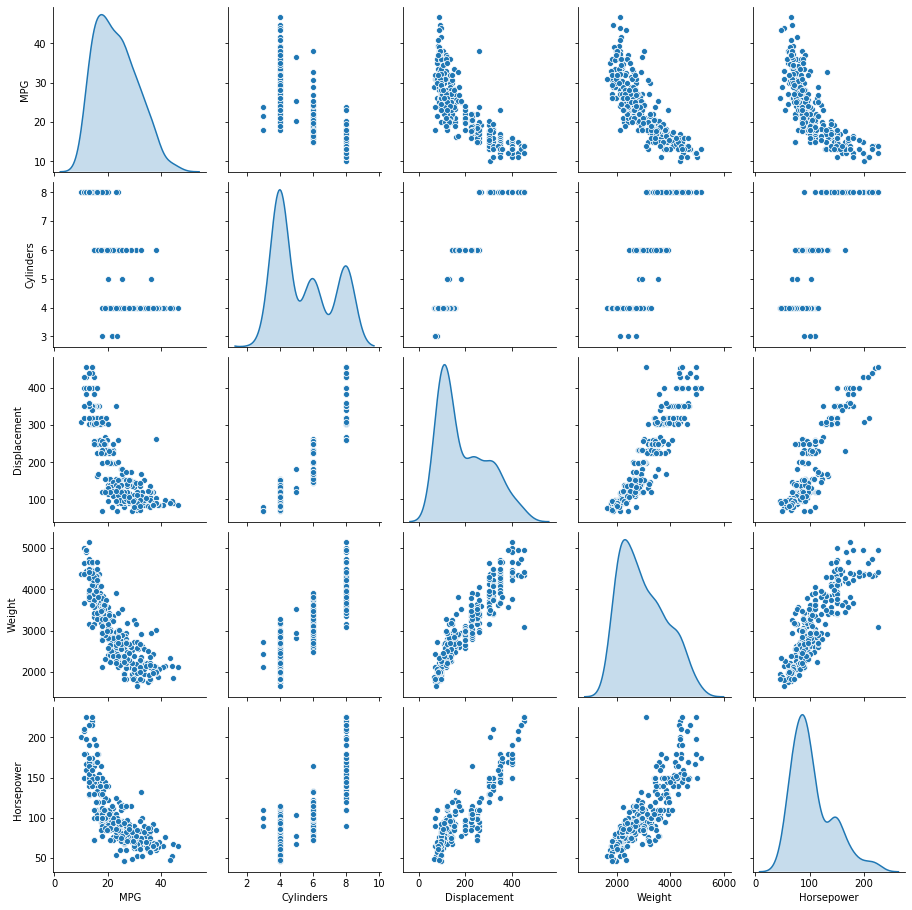

In [19]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight','Horsepower']], diag_kind='kde')

#### MPG clearly depends on Displacement and Weight

In [20]:
train_dataset.corr()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
MPG,1.000000,-0.770246,-0.800383,-0.764545,-0.819802,0.395955,0.574117,-0.564179,0.237424,0.458106
Cylinders,-0.770246,1.000000,0.946806,0.844247,0.893869,-0.506000,-0.338375,0.605872,-0.361548,-0.389472
Displacement,-0.800383,0.946806,1.000000,0.902151,0.929876,-0.545912,-0.363671,0.658756,-0.386149,-0.430157
Horsepower,-0.764545,0.844247,0.902151,1.000000,0.857417,-0.699720,-0.394927,0.490041,-0.301778,-0.306020
Weight,-0.819802,0.893869,0.929876,0.857417,1.000000,-0.412728,-0.284673,0.599531,-0.306898,-0.434309
Acceleration,0.395955,-0.506000,-0.545912,-0.699720,-0.412728,1.000000,0.276164,-0.265427,0.227893,0.103788
Model Year,0.574117,-0.338375,-0.363671,-0.394927,-0.284673,0.276164,1.000000,-0.127264,-0.075476,0.227418
Origin_1,-0.564179,0.605872,0.658756,0.490041,0.599531,-0.265427,-0.127264,1.000000,-0.600442,-0.639267
Origin_2,0.237424,-0.361548,-0.386149,-0.301778,-0.306898,0.227893,-0.075476,-0.600442,1.000000,-0.231089
Origin_3,0.458106,-0.389472,-0.430157,-0.306020,-0.434309,0.103788,0.227418,-0.639267,-0.231089,1.000000


In [21]:
x_train=train_dataset.copy()
x_test=test_dataset.copy()

y_train=x_train.pop('MPG')
y_test=x_test.pop('MPG')

### Normalization 

In [22]:
x_train.describe().transpose()[['mean','std']]

,mean,std
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Origin_1,0.624204,0.485101
Origin_2,0.178344,0.383413
Origin_3,0.197452,0.398712


##### Highly varying range of values, this will result in different weight assignment

In [23]:
normalizer=preprocessing.Normalization()  # NORMALIZATION LAYER

### SIMPLE LINEAR REGRESSION USING ONE VARIABLE
#### Using 'Displacement' to build simple linear model i.e. Y= A x + b where A and b are learnable parameters and x is feature vector of 'DIsplacement'

In [45]:
# NORMALIZATION
displacement=np.array(x_train['Displacement'])
displacement_normalizer=preprocessing.Normalization()
displacement_normalizer.adapt(displacement)

In [46]:
# TINY FUNCTIONAL MODEL

inputs=Input(shape=(1,))
x=displacement_normalizer(inputs)
x=Dense(1)(x)
linear_model=Model(inputs,x)

In [47]:
%%time
linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error')
history = linear_model.fit(
    x_train['Displacement'], y_train,
    epochs=200,
    verbose=1,
    validation_split = 0.2)

Epoch 1/200
8/8 [==============================] - 2s 31ms/step - loss: 23.2667 - val_loss: 22.9252
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 21.7546 - val_loss: 22.1248
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 21.1022 - val_loss: 21.3243
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 20.9898 - val_loss: 20.5251
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 20.1131 - val_loss: 19.7252
Epoch 6/200
8/8 [==============================] - 0s 9ms/step - loss: 19.3459 - val_loss: 18.9253
Epoch 7/200
8/8 [==============================] - 0s 24ms/step - loss: 18.6576 - val_loss: 18.1257
Epoch 8/200
8/8 [==============================] - 0s 11ms/step - loss: 17.1195 - val_loss: 17.3247
Epoch 9/200
8/8 [==============================] - 0s 11ms/step - loss: 16.0976 - val_loss: 16.5251
Epoch 10/200
8/8 [==============================] - 0s 11ms/step - loss: 15.3572 - val_loss: 15.7247
Ep

In [48]:
hist=pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,val_loss,epoch
0,22.866985,22.925230,0
1,22.065563,22.124763,1
2,21.267023,21.324329,2
3,20.465338,20.525061,3
4,19.663734,19.725185,4


In [51]:
def plot_loss(history):
    
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

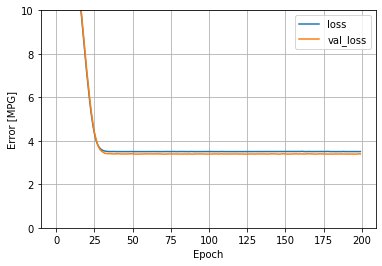

In [52]:
plot_loss(history)

In [62]:
l=[]
for a in linear_model.trainable_variables:
    l.append(a.numpy())
print(f' The learned equation of line is Y = {l[0].flatten()} * x + {l[1]}')

 The learned equation of line is Y = [-5.6944065] * x + [22.382318]


In [63]:
linear_model.evaluate(x_test['Displacement'],y_test)

3/3 [==============================] - 0s 2ms/step - loss: 3.5937


3.593708038330078

### MAKING PREDICTIONS ON TEST DATA

In [64]:
y=linear_model.predict(x_test['Displacement'])

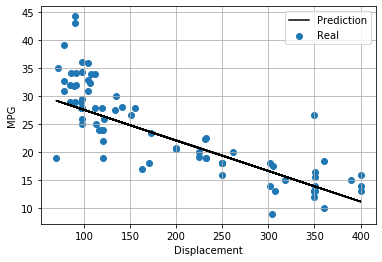

In [65]:
plt.scatter(x_test['Displacement'],y_test,label='Real')
plt.plot(x_test['Displacement'],y,label='Prediction',color='k')
plt.xlabel('Displacement')
plt.ylabel('MPG')
plt.legend()
plt.grid(True)

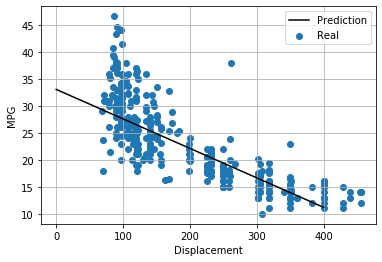

In [66]:
x=tf.linspace(0.0,400,401)
y=linear_model.predict(x)
plt.scatter(x_train['Displacement'],y_train,label='Real')
plt.plot(x,y,label='Prediction',color='k')
plt.xlabel('Displacement')
plt.ylabel('MPG')
plt.legend()
plt.grid(True)

#### The simple linear model cannot be used to model this distribution since there are some non linearities in the dataset. It can be corrected by introducing some non linearities using activation functions like ReLU or LeakyReLU

### Linear Model With Added Non Linearities

In [67]:
inputs=Input(shape=(1,))
x=displacement_normalizer(inputs)
x=Dense(64)(x)
x=LeakyReLU(alpha=0.01)(x)
x=Dense(64)(x)
x=LeakyReLU(alpha=0.01)(x)
x=Dense(1)(x)
Non_linear_model=Model(inputs,x)

In [71]:
%%time
Non_linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss='mean_absolute_error',metrics=['mse'])
history = Non_linear_model.fit(
    x_train['Displacement'], y_train,
    epochs=200,
    verbose=1,
    validation_split = 0.2)

Epoch 1/200
8/8 [==============================] - 1s 44ms/step - loss: 3.1855 - mse: 20.2825 - val_loss: 2.9841 - val_mse: 16.7669
Epoch 2/200
8/8 [==============================] - 0s 11ms/step - loss: 3.1996 - mse: 19.6981 - val_loss: 2.9654 - val_mse: 17.3975
Epoch 3/200
8/8 [==============================] - 0s 11ms/step - loss: 3.2796 - mse: 21.4312 - val_loss: 2.9913 - val_mse: 17.6808
Epoch 4/200
8/8 [==============================] - 0s 13ms/step - loss: 3.2099 - mse: 21.3866 - val_loss: 2.9835 - val_mse: 17.5131
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 3.2115 - mse: 19.9205 - val_loss: 2.9710 - val_mse: 16.9410
Epoch 6/200
8/8 [==============================] - 0s 11ms/step - loss: 3.2594 - mse: 21.4485 - val_loss: 2.9670 - val_mse: 17.0187
Epoch 7/200
8/8 [==============================] - 0s 10ms/step - loss: 3.0973 - mse: 18.2369 - val_loss: 2.9795 - val_mse: 17.7439
Epoch 8/200
8/8 [==============================] - 0s 11ms/step - loss: 3.29

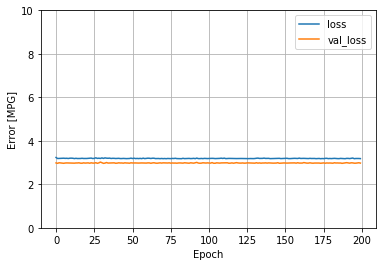

In [72]:
plot_loss(history)

In [73]:
Non_linear_model.evaluate(x_test['Displacement'],y_test)

3/3 [==============================] - 0s 2ms/step - loss: 3.0919 - mse: 19.4453


[3.0918681621551514, 19.445322036743164]

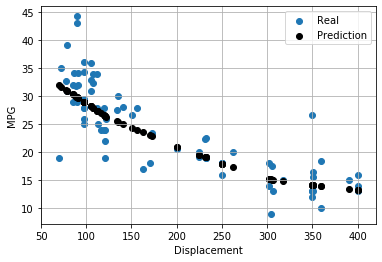

In [74]:
y=Non_linear_model.predict(x_test['Displacement'])
plt.scatter(x_test['Displacement'],y_test,label='Real')
plt.scatter(x_test['Displacement'],y,label='Prediction',color='k')
plt.xlabel('Displacement')
plt.ylabel('MPG')
plt.legend()
plt.grid(True)

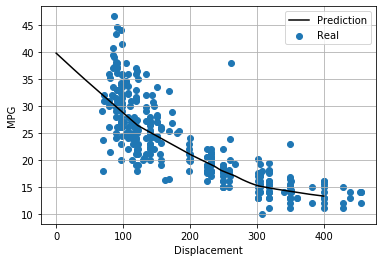

In [75]:
x=tf.linspace(0.0,400,401)
y=Non_linear_model.predict(x)
plt.scatter(x_train['Displacement'],y_train,label='Real')
plt.plot(x,y,label='Prediction',color='k')
plt.xlabel('Displacement')
plt.ylabel('MPG')
plt.legend()
plt.grid(True)

#### The Non - Linear Model is Fitting Pretty Well on Data, But there is still some hyperparameter tuning needs to be done

### Hyperparameter Tuning with keras-tuner

In [76]:
def model_builder(hp):
    model=Sequential()
    hp_units1=hp.Int('units1',min_value=32,max_value=64,step=8)
    model.add(Dense(units=hp_units1,input_shape = (1,)))
    model.add(LeakyReLU(alpha=0.01))
    hp_units2=hp.Int('units2',min_value=32,max_value=64,step=8)
    model.add(Dense(units=hp_units2))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1))
    hp_learning_rate= hp.Choice('learning_rate',values=[1e-1,1e-2,1e-3])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss='mae',metrics=['mae'])
    return model

In [77]:
tuner=kt.Hyperband(model_builder,objective='mae',max_epochs=30,factor=3,directory='Untitled Folder 2',project_name='Untitled Folder')

INFO:tensorflow:Reloading Oracle from existing project Untitled Folder 2\Untitled Folder\oracle.json
INFO:tensorflow:Reloading Tuner from Untitled Folder 2\Untitled Folder\tuner0.json


In [78]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=5)


In [79]:
tuner.search(x_train['Displacement'],y_train,epochs=100,validation_split=0.2,callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')} , the optimal number of units in second densly-connected layer is {best_hps.get('units2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 32 , the optimal number of units in second densly-connected layer is 48 and the optimal learning rate for the optimizer
is 0.1.



In [80]:
model=tuner.hypermodel.build(best_hps)
history=model.fit(x_train['Displacement'],y_train,epochs=100,validation_split=.2)
mae_per_epoch = history.history['mae']
best_epoch = mae_per_epoch.index(min(mae_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/100
8/8 [==============================] - 0s 21ms/step - loss: 96.3892 - mae: 96.3892 - val_loss: 15.6180 - val_mae: 15.6180
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 14.0880 - mae: 14.0880 - val_loss: 15.1473 - val_mae: 15.1473
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 13.8219 - mae: 13.8219 - val_loss: 17.1779 - val_mae: 17.1779
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 17.6554 - mae: 17.6554 - val_loss: 14.2739 - val_mae: 14.2739
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 13.6545 - mae: 13.6545 - val_loss: 15.0825 - val_mae: 15.0825
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 13.3567 - mae: 13.3567 - val_loss: 13.4637 - val_mae: 13.4637
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 11.8830 - mae: 11.8830 - val_loss: 12.5760 - val_mae: 12.5760
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - los

In [81]:
hypermodel=tuner.hypermodel.build(best_hps)
hypermodel.fit(x_train['Displacement'],y_train,epochs=best_epoch,validation_split=0.2)

Epoch 1/30
8/8 [==============================] - 0s 21ms/step - loss: 80.9470 - mae: 80.9470 - val_loss: 18.3137 - val_mae: 18.3137
Epoch 2/30
8/8 [==============================] - 0s 7ms/step - loss: 16.8885 - mae: 16.8885 - val_loss: 14.4730 - val_mae: 14.4730
Epoch 3/30
8/8 [==============================] - 0s 8ms/step - loss: 12.8299 - mae: 12.8299 - val_loss: 14.1597 - val_mae: 14.1597
Epoch 4/30
8/8 [==============================] - 0s 8ms/step - loss: 13.4037 - mae: 13.4037 - val_loss: 15.1808 - val_mae: 15.1808
Epoch 5/30
8/8 [==============================] - 0s 8ms/step - loss: 13.2966 - mae: 13.2966 - val_loss: 13.6270 - val_mae: 13.6270
Epoch 6/30
8/8 [==============================] - 0s 8ms/step - loss: 11.3497 - mae: 11.3497 - val_loss: 9.7008 - val_mae: 9.7008
Epoch 7/30
8/8 [==============================] - 0s 8ms/step - loss: 8.5296 - mae: 8.5296 - val_loss: 6.8968 - val_mae: 6.8968
Epoch 8/30
8/8 [==============================] - 0s 8ms/step - loss: 5.5722 - ma

In [83]:
hypermodel.evaluate(x_test['Displacement'],y_test)

3/3 [==============================] - 0s 2ms/step - loss: 3.7786 - mae: 3.7786


[3.778623104095459, 3.778623104095459]

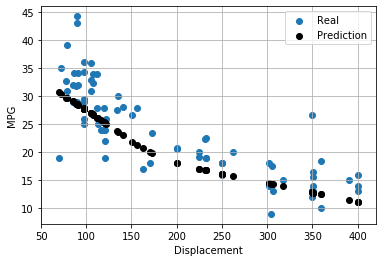

In [84]:
#y=hypermodel.predict(x_test['Displacement'])
y=hypermodel.predict(x_test['Displacement'])
plt.scatter(x_test['Displacement'],y_test,label='Real')
plt.scatter(x_test['Displacement'],y,label='Prediction',color='k')
plt.xlabel('Displacement')
plt.ylabel('MPG')
plt.legend()
plt.grid(True)

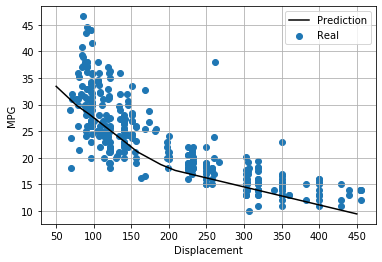

In [85]:
x=tf.linspace(50,450,501)
y=hypermodel.predict(x)
plt.scatter(x_train['Displacement'],y_train,label='Real')
plt.plot(x,y,label='Prediction',color='k')
plt.xlabel('Displacement')
plt.ylabel('MPG')
plt.legend()
plt.grid(True)